<a href="https://colab.research.google.com/github/anurag25/shared_notebooks/blob/master/plant_pathology2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
!nvidia-smi

Fri May 15 06:28:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate, accuracy
from sklearn.metrics import roc_auc_score
from fastai.callbacks import *
import warnings
warnings.filterwarnings("ignore")

In [8]:
device = torch.cuda.set_device(0)
print(torch.cuda.get_device_name(device))
print(torch.cuda.get_device_properties(device))

Tesla P100-PCIE-16GB
_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [9]:
path_img = Path("/content/drive/My Drive/kaggle/input/plant_data/images")
path_ano = Path("/content/drive/My Drive/kaggle/input/plant_data/")
path_out = Path("/content/drive/My Drive/kaggle/working/")
path_ano.ls()

[PosixPath('/content/drive/My Drive/kaggle/input/plant_data/sample_submission.csv'),
 PosixPath('/content/drive/My Drive/kaggle/input/plant_data/train.csv'),
 PosixPath('/content/drive/My Drive/kaggle/input/plant_data/test.csv'),
 PosixPath('/content/drive/My Drive/kaggle/input/plant_data/images')]

In [10]:
train_df = pd.read_csv(path_ano/"train.csv")
train_df["image_id"] = train_df["image_id"] + ".jpg"
train_df["label"] = 0 * train_df.healthy + 1 * train_df.multiple_diseases + 2 * train_df.rust + 3 * train_df.scab
labels = ["healthy", "multiple_diseases", "rust", "scab"]
for i in range(len(train_df)):
    train_df.label[i] = labels[train_df.label[i]]
train_df = train_df.drop(columns = ["healthy", "multiple_diseases", "rust", "scab"])
print(train_df.label.value_counts())
train_df.head()

rust                 622
scab                 592
healthy              516
multiple_diseases     91
Name: label, dtype: int64


,image_id,label
0,Train_0.jpg,scab
1,Train_1.jpg,multiple_diseases
2,Train_2.jpg,healthy
3,Train_3.jpg,rust
4,Train_4.jpg,healthy


(None, None)

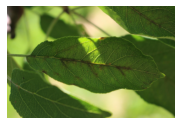

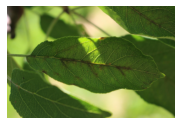

In [11]:
#label correction
img1, img2 = open_image(path_img/'Train_379.jpg'), open_image(path_img/'Train_1173.jpg')
img1.show(), img2.show()

In [12]:
train_df.loc[train_df["image_id"] == "Train_379.jpg"]

,image_id,label
379,Train_379.jpg,scab


In [13]:
train_df.loc[train_df["image_id"] == "Train_1173.jpg"]

,image_id,label
1173,Train_1173.jpg,multiple_diseases


In [0]:
train_df.loc[379, "label"] = "multiple_diseases"

In [15]:
train_df.loc[train_df["image_id"] == "Train_379.jpg"]

,image_id,label
379,Train_379.jpg,multiple_diseases


In [16]:
train_df.label.value_counts()

rust                 622
scab                 591
healthy              516
multiple_diseases     92
Name: label, dtype: int64

In [29]:
bs = 8
data = ImageList.from_df(train_df, path_img)
data = data.split_by_rand_pct(seed = 42)
data = data.label_from_df(['label'])
ds_tfms = get_transforms(do_flip = True, flip_vert =True, max_rotate = 90.0, max_zoom =1.5, max_lighting =0.4, max_warp =0.4, p_affine = 0.75, p_lighting =0.75)
data = data.transform(ds_tfms, size = 768)
data = data.databunch(bs = bs)
data = data.normalize(imagenet_stats)
data

ImageDataBunch;

Train: LabelList (1457 items)
x: ImageList
Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768)
y: CategoryList
scab,multiple_diseases,healthy,rust,healthy
Path: /content/drive/My Drive/kaggle/input/plant_data/images;

Valid: LabelList (364 items)
x: ImageList
Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768)
y: CategoryList
rust,healthy,healthy,rust,healthy
Path: /content/drive/My Drive/kaggle/input/plant_data/images;

Test: None

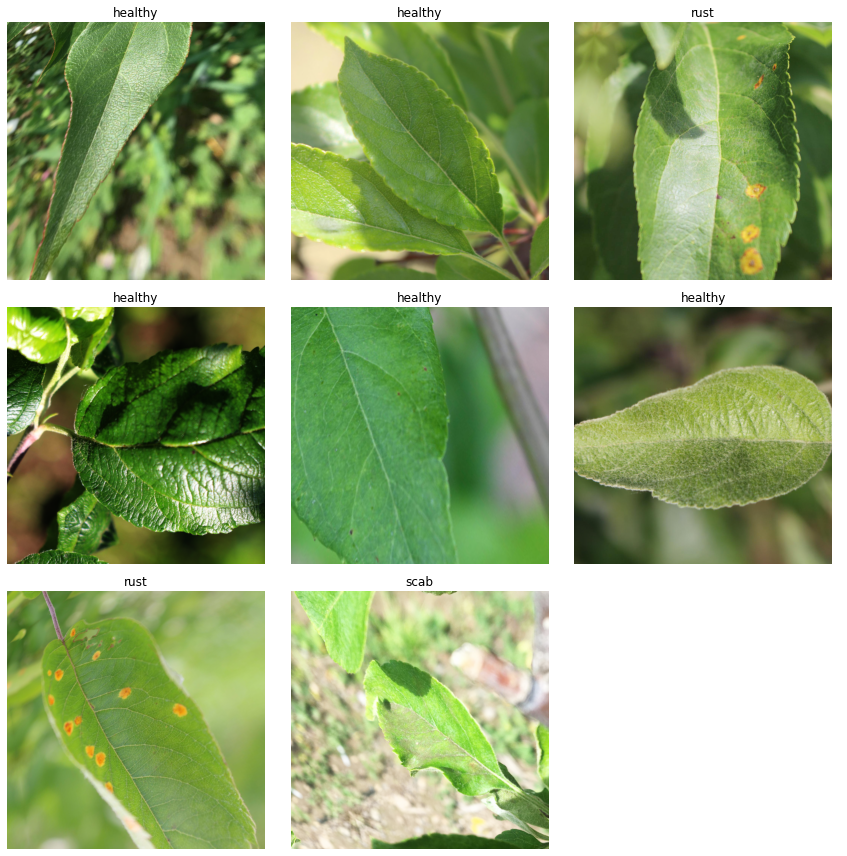

In [30]:
data.show_batch(5)

In [31]:
test_df = pd.read_csv(path_ano/"test.csv")
test_df["image_id"] = test_df["image_id"] + ".jpg"
test_data = ImageList.from_df(test_df, path_img)
data.add_test(test_data)
test_data

ImageList (1821 items)
Image (3, 1365, 2048),Image (3, 1365, 2048),Image (3, 1365, 2048),Image (3, 1365, 2048),Image (3, 1365, 2048)
Path: /content/drive/My Drive/kaggle/input/plant_data/images

In [32]:
data

ImageDataBunch;

Train: LabelList (1457 items)
x: ImageList
Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768)
y: CategoryList
scab,multiple_diseases,healthy,rust,healthy
Path: /content/drive/My Drive/kaggle/input/plant_data/images;

Valid: LabelList (364 items)
x: ImageList
Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768)
y: CategoryList
rust,healthy,healthy,rust,healthy
Path: /content/drive/My Drive/kaggle/input/plant_data/images;

Test: LabelList (1821 items)
x: ImageList
Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768),Image (3, 768, 768)
y: EmptyLabelList
,,,,
Path: /content/drive/My Drive/kaggle/input/plant_data/images

In [0]:
def auroc_score(input, target):
    input, target = input.cpu().numpy(), target.cpu().numpy()
    return roc_auc_score(input, target)

@dataclass
class AUC(Callback):
    clas:int=1
    _order = -30
    
    def __init__(self, clas, **kwargs):
        super().__init__()
        self.clas = clas
        self.temp_list = ["healthy", "multiple_diseases", "rust", "scab"]
        self.name = "auc_" + str(self.temp_list[self.clas])
        self.roc = 0
    
    def on_epoch_begin(self, **kwargs):
        self.output, self.target = [], []
    
    def on_batch_end(self, last_output, last_target, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
    def on_epoch_end(self, last_metrics, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            considered_clas = self.clas
            indexes = (target == considered_clas)
            target_for_roc = torch.zeros(target.size())
            target_for_roc[indexes] = 1
            probs = F.softmax(output, dim = 1)
            pfinal = probs[:, considered_clas]
            self.metric = auroc_score(target_for_roc, pfinal)
            self.roc = self.metric
        return add_metrics(last_metrics, self.metric)

In [0]:
class MeanAUC(Callback):
    _order = -20
    
    def __init__(self, auc0, auc1, auc2, auc3):
        super().__init__()
        self.name = "Mean AUC"
        self.auc0 = auc0
        self.auc1 = auc1
        self.auc2 = auc2
        self.auc3 = auc3
    
    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics, (self.auc0.roc + self.auc1.roc + self.auc2.roc + self.auc3.roc) / 4)

In [35]:
auc0 = AUC(clas=0)
auc1 = AUC(clas=1)
auc2 = AUC(clas=2)
auc3 = AUC(clas=3)
meanauc = MeanAUC(auc0, auc1, auc2, auc3)
learn = cnn_learner(data, models.resnet50, metrics = [accuracy, error_rate, auc0, auc1, auc2, auc3, meanauc]).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [37]:
learn.model_dir = path_out
learn.fit_one_cycle(5, callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = 'best_stage1')])

epoch,train_loss,valid_loss,accuracy,error_rate,auc_healthy,auc_multiple_diseases,auc_rust,auc_scab,Mean AUC,time
0,1.196802,0.685796,0.758242,0.241758,0.938485,0.812139,0.962090,0.947212,0.914981,08:53
1,0.927734,0.430989,0.870879,0.129121,0.971553,0.885196,0.988525,0.969955,0.953807,03:59
2,0.634505,0.380858,0.879121,0.120879,0.970038,0.862717,0.992281,0.974690,0.949931,04:01
3,0.519513,0.258645,0.903846,0.096154,0.984432,0.919236,0.995867,0.988629,0.972041,04:04
4,0.425664,0.244187,0.925824,0.074176,0.987273,0.925498,0.996892,0.989863,0.974881,04:03


Better model found at epoch 0 with valid_loss value: 0.6857962012290955.
Better model found at epoch 1 with valid_loss value: 0.43098872900009155.
Better model found at epoch 2 with valid_loss value: 0.380858451128006.
Better model found at epoch 3 with valid_loss value: 0.25864505767822266.
Better model found at epoch 4 with valid_loss value: 0.24418744444847107.


epoch,train_loss,valid_loss,accuracy,error_rate,auc_healthy,auc_multiple_diseases,auc_rust,auc_scab,Mean AUC,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.20E-06


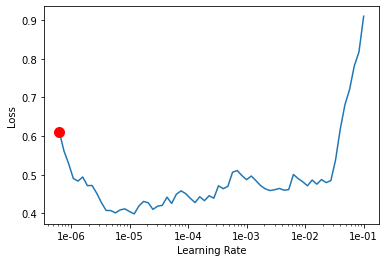

In [38]:
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [40]:
learn.model_dir = path_out
learn.load('best_stage1')
learn.unfreeze()
learn.fit_one_cycle(5, max_lr = slice(6.31E-07, 1E-04), callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = 'best_stage2')])

epoch,train_loss,valid_loss,accuracy,error_rate,auc_healthy,auc_multiple_diseases,auc_rust,auc_scab,Mean AUC,time
0,0.453515,0.238294,0.920330,0.079670,0.986023,0.946532,0.996995,0.989663,0.979803,04:07
1,0.419677,0.190655,0.925824,0.074176,0.990568,0.964194,0.998292,0.991063,0.986029,04:05
2,0.407211,0.167188,0.950549,0.049451,0.992159,0.947174,0.999522,0.992964,0.982955,04:07
3,0.364327,0.190720,0.950549,0.049451,0.991780,0.951028,0.998975,0.990896,0.983170,04:08
4,0.364629,0.195421,0.939560,0.060440,0.991212,0.945408,0.999283,0.990863,0.981691,04:05


Better model found at epoch 0 with valid_loss value: 0.23829437792301178.
Better model found at epoch 1 with valid_loss value: 0.19065532088279724.
Better model found at epoch 2 with valid_loss value: 0.16718840599060059.


epoch,train_loss,valid_loss,accuracy,error_rate,auc_healthy,auc_multiple_diseases,auc_rust,auc_scab,Mean AUC,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 9.12E-08


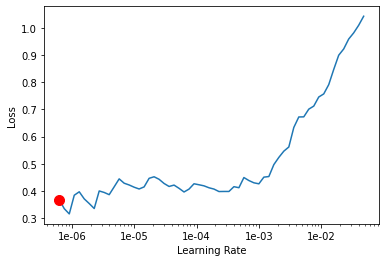

In [42]:
learn.load("best_stage2")
learn.lr_find()
learn.recorder.plot(suggestion = True)

In [43]:
learn.model_dir = path_out
learn.fit_one_cycle(5, max_lr = slice(9.12E-08, 6.31E-07), callbacks=[SaveModelCallback(learn, every='improvement', monitor='valid_loss', name = 'best_stage3')])

epoch,train_loss,valid_loss,accuracy,error_rate,auc_healthy,auc_multiple_diseases,auc_rust,auc_scab,Mean AUC,time
0,0.335602,0.206623,0.939560,0.060440,0.990417,0.946211,0.998941,0.991530,0.981775,04:07
1,0.391819,0.196459,0.939560,0.060440,0.991932,0.941394,0.999146,0.990696,0.980792,04:09
2,0.377627,0.185049,0.945055,0.054945,0.990985,0.947013,0.999214,0.991397,0.982152,04:13
3,0.376145,0.198476,0.936813,0.063187,0.991553,0.950546,0.999180,0.992497,0.983444,04:16
4,0.389558,0.201864,0.934066,0.065934,0.992045,0.944766,0.998839,0.991330,0.981745,04:12


Better model found at epoch 0 with valid_loss value: 0.20662273466587067.
Better model found at epoch 1 with valid_loss value: 0.19645901024341583.
Better model found at epoch 2 with valid_loss value: 0.18504925072193146.


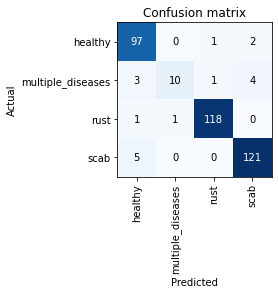

In [44]:
learn.load("best_stage2")
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

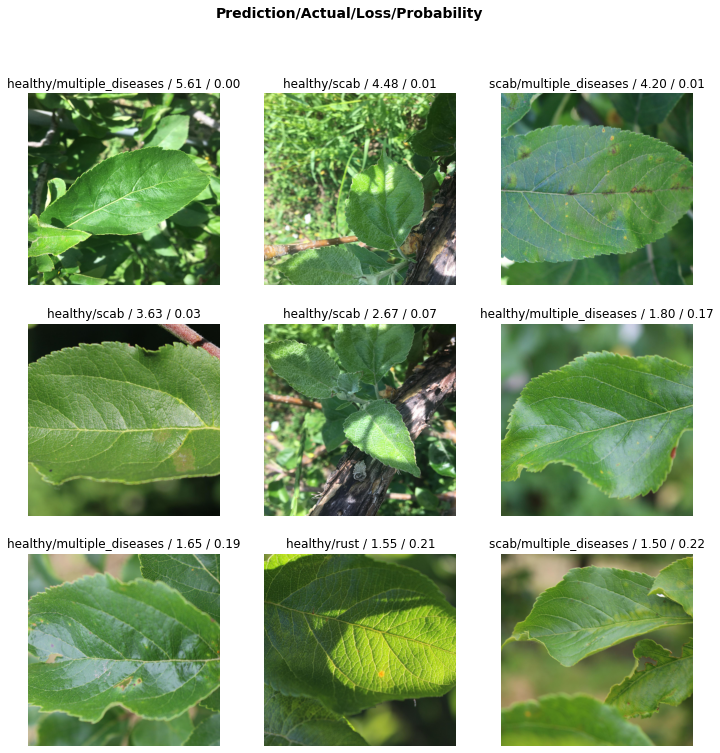

In [45]:
interp.plot_top_losses(9)

In [47]:
interp.most_confused(2)

[('scab', 'healthy', 5),
 ('multiple_diseases', 'scab', 4),
 ('multiple_diseases', 'healthy', 3),
 ('healthy', 'scab', 2)]

In [48]:
preds, y = learn.get_preds(DatasetType.Test)
preds_np = preds.numpy()
px = pd.DataFrame(preds_np)

In [49]:
submit = pd.read_csv(path_ano/"sample_submission.csv")
submit.healthy = px[0]
submit.multiple_diseases = px[1]
submit.rust = px[2]
submit.scab = px[3]
print(submit.head())
submit.to_csv(path_out/"submission_resnet50_best2.csv", index = False)

  image_id       healthy  multiple_diseases          rust      scab
0   Test_0  2.161625e-03           0.050716  9.410837e-01  0.006039
1   Test_1  6.291742e-05           0.073951  9.231741e-01  0.002812
2   Test_2  2.393901e-04           0.000018  4.645070e-07  0.999742
3   Test_3  9.897363e-01           0.000014  8.307553e-03  0.001943
4   Test_4  2.849507e-07           0.000622  9.993631e-01  0.000015
